In [10]:
import os
import glob
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from types import SimpleNamespace
import albumentations as A
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import pydicom

def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [11]:
def convert_to_8bit(x):
    lower, upper = np.percentile(x, (1, 99))
    x = np.clip(x, lower, upper)
    x = x - np.min(x)
    x = x / np.max(x) 
    return (x * 255).astype("uint8")

In [12]:
def load_dicom_stack(dicom_folder, plane, reverse_sort=False):
    dicom_files = glob.glob(os.path.join(dicom_folder, "*.dcm"))
    dicoms = [pydicom.dcmread(f) for f in dicom_files]
    plane = {"sagittal": 0, "coronal": 1, "axial": 2}[plane.lower()]
    positions = np.asarray([float(d.ImagePositionPatient[plane]) for d in dicoms])
    # if reverse_sort=False, then increasing array index will be from RIGHT->LEFT and CAUDAL->CRANIAL
    # thus we do reverse_sort=True for axial so increasing array index is craniocaudal
    idx = np.argsort(-positions if reverse_sort else positions)
    ipp = np.asarray([d.ImagePositionPatient for d in dicoms]).astype("float")[idx]
    array = np.stack([d.pixel_array.astype("float32") for d in dicoms])
    array = array[idx]
    return {"array": convert_to_8bit(array), "positions": ipp, "pixel_spacing": np.asarray(dicoms[0].PixelSpacing).astype("float")}

image_dir = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/"

In [13]:
resize_transform= A.Compose([
    A.LongestMaxSize(max_size=256, interpolation=cv2.INTER_CUBIC, always_apply=True),
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0), always_apply=True),
])

In [14]:
def angle_of_line(x1, y1, x2, y2):
    return math.degrees(math.atan2(-(y2-y1), x2-x1))

In [15]:
def plot_img(img, coords_temp):
    # Plot img
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    h, w = img.shape
    
    # Kepoints as pairs
    p= coords_temp.groupby("level") \
                  .apply(lambda g: list(zip(g['relative_x'], g['relative_y'])), include_groups=False) \
                  .reset_index(drop=False, name="vals")
    
    # Plot keypoints
    for _, row in p.iterrows():
        level = row['level']
        x = [_[0]*w for _ in row["vals"]]
        y = [_[1]*h for _ in row["vals"]]
        ax.plot(x, y, marker='o')
    ax.axis('off')
    plt.show()

In [16]:
def plot_5_crops(img, coords_temp):
    # Create a figure and axis for the grid
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(1, 5, width_ratios=[1]*5)
    
    # Plot the crops
    p= coords_temp.groupby("level").apply(lambda g: list(zip(g['relative_x'], g['relative_y'])), include_groups=False).reset_index(drop=False, name="vals")
    for idx, (_, row) in enumerate(p.iterrows()):
        # Copy of img
        img_copy= img.copy()
        h, w = img.shape

        # Extract Keypoints
        level = row['level']
        vals = sorted(row["vals"], key=lambda x: x[0])
        a,b= vals
        a= (a[0]*w, a[1]*h)
        b= (b[0]*w, b[1]*h)

        # Rotate
        rotate_angle= angle_of_line(a[0], a[1], b[0], b[1])
        transform = A.Compose([
            A.Rotate(limit=(-rotate_angle, -rotate_angle), p=1.0),
        ], keypoint_params= A.KeypointParams(format='xy', remove_invisible=False),
        )

        t= transform(image=img_copy, keypoints=[a,b])
        img_copy= t["image"]
        a,b= t["keypoints"]
        
        # Crop + Resize
        img_copy= crop_between_keypoints(img_copy, a, b)
        img_copy= resize_transform(image=img_copy)["image"]
        
        # Plot
        ax = plt.subplot(gs[idx])
        ax.imshow(img_copy, cmap='gray')
        ax.set_title(level)
        ax.axis('off')
    plt.show()

In [17]:
def crop_between_keypoints(img, keypoint1, keypoint2):
    h, w = img.shape
    x1, y1 = int(keypoint1[0]), int(keypoint1[1])
    x2, y2 = int(keypoint2[0]), int(keypoint2[1])
    
    # Calculate bounding box around the keypoints
    left = int(min(x1, x2))
    right = int(max(x1, x2))
    top = int(min(y1, y2) - (h * 0.1))
    bottom = int(max(y1, y2) + (h * 0.1))
            
    # Crop the image
    return img[top:bottom, left:right]

In [19]:
SEED= 10
N= 2

# Load series_ids
dfd= pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv")
dfd= dfd[dfd.series_description == "Sagittal T2/STIR"]
dfd= dfd.sample(frac=1, random_state=SEED).head(N)

# Load coords
coords= pd.read_csv("/kaggle/input/lumbar-coordinate-pretraining-dataset/coords_rsna_improved.csv")
coords= coords.sort_values(["series_id", "level", "side"]).reset_index(drop=True)
coords= coords[["series_id", "level", "side", "relative_x", "relative_y"]]

-------------------------  STUDY_ID: 153831832, SERIES_ID: 2054214528  -------------------------


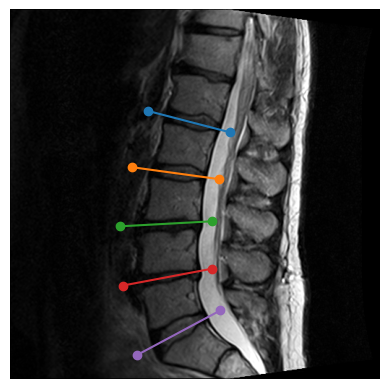

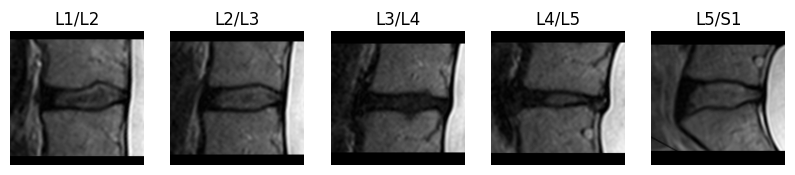

-------------------------  STUDY_ID: 200852737, SERIES_ID: 680111404  -------------------------


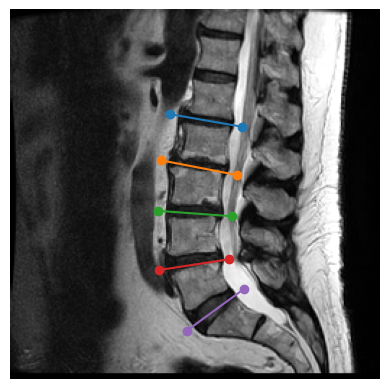

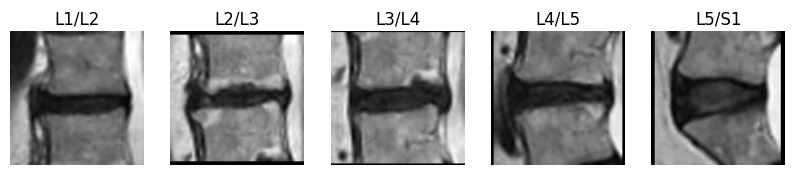

In [20]:
# Plot samples
for idx, row in dfd.iterrows():
    try:
        print("-"*25, " STUDY_ID: {}, SERIES_ID: {} ".format(row.study_id, row.series_id), "-"*25)
        sag_t2 = load_dicom_stack(os.path.join(image_dir, str(row.study_id), str(row.series_id)), plane="sagittal")
        
        # Img + Coords
        img= sag_t2["array"][len(sag_t2["array"])//2]
        coords_temp= coords[coords["series_id"] == row.series_id].copy()
        
        # Plot
        plot_img(img, coords_temp)
        plot_5_crops(img, coords_temp)
        
    except Exception as e:
        print(e)
        pass

In [21]:
# Config
cfg= SimpleNamespace(
    img_dir= "/kaggle/input/lumbar-coordinate-pretraining-dataset/data/",
    device= torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    n_frames=3,
    epochs=10,
    lr=0.0005,
    batch_size=16,
    backbone="resnet18",
    seed= 0,
)
set_seed(seed=cfg.seed) # Makes results reproducable

In [22]:
# Load metadata
df= pd.read_csv("/kaggle/input/lumbar-coordinate-pretraining-dataset/coords_pretrain.csv")
df= df.sort_values(["source", "filename", "level"]).reset_index(drop=True)
df["filename"] = df["filename"].str.replace(".jpg", ".npy")
df["series_id"] = df["source"] + "_" + df["filename"].str.split(".").str[0]

print("----- IMGS per source -----")
display((df.source.value_counts()/5).astype(int).reset_index())

----- IMGS per source -----


,source,count
0,lsd,504
1,tseg,375
2,spider,209
3,osf,33


In [23]:
class PreTrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, cfg):
        self.cfg= cfg
        self.records= self.load_coords(df)

    def load_coords(self, df):
        # Convert to dict
        d = df.groupby("series_id")[["relative_x", "relative_y"]].apply(lambda x: list(x.itertuples(index=False, name=None)))
        records= {}
        for i, (k,v) in enumerate(d.items()):
            records[i]= {"series_id": k, "label": np.array(v).flatten()}
            assert len(v) == 5
            
        return records
    
    def pad_image(self, img):
        n= img.shape[-1]
        if n >= self.cfg.n_frames:
            start_idx = (n - self.cfg.n_frames) // 2
            return img[:, :, start_idx:start_idx + self.cfg.n_frames]
        else:
            pad_left = (self.cfg.n_frames - n) // 2
            pad_right = self.cfg.n_frames - n - pad_left
            return np.pad(img, ((0,0), (0,0), (pad_left, pad_right)), 'constant', constant_values=0)
    
    def load_img(self, source, series_id):
        fname= os.path.join(self.cfg.img_dir, "processed_{}/{}.npy".format(source, series_id))
        img= np.load(fname).astype(np.float32)
        img= self.pad_image(img)
        img= np.transpose(img, (2, 0, 1))
        img= (img / 255.0)
        return img
        
        
    def __getitem__(self, idx):
        d= self.records[idx]
        label= d["label"]
        source= d["series_id"].split("_")[0]
        series_id= "_".join(d["series_id"].split("_")[1:])     
                
        img= self.load_img(source, series_id)
        return {
            'img': img, 
            'label': label,
            }
    
    def __len__(self,):
        return len(self.records)
    
ds= PreTrainDataset(df, cfg)    

# Plot a Single Sample
print("---- Sample Shapes -----")
for k, v in ds[0].items():
    print(k, v.shape)

---- Sample Shapes -----
img (3, 256, 256)
label (10,)


In [24]:
def batch_to_device(batch, device, skip_keys=[]):
    batch_dict= {}
    for key in batch:
        if key in skip_keys:
             batch_dict[key]= batch[key]
        else:    
            batch_dict[key]= batch[key].to(device)
    return batch_dict

def visualize_prediction(batch, pred, epoch):
    
    mid= cfg.n_frames//2
    
    # Plot
    for idx in range(1):
    
        # Select Data
        img= batch["img"][idx, mid, :, :].cpu().numpy()*255
        cs_true= batch["label"][idx, ...].cpu().numpy()*256
        cs= pred[idx, ...].cpu().numpy()*256
                
        coords_list = [("TRUE", "lightblue", cs_true), ("PRED", "orange", cs)]
        text_labels = [str(x) for x in range(1,6)]
        
        # Plot coords
        fig, axes = plt.subplots(1, len(coords_list), figsize=(10,4))
        fig.suptitle("EPOCH: {}".format(epoch))
        for ax, (title, color, coords) in zip(axes, coords_list):
            ax.imshow(img, cmap='gray')
            ax.scatter(coords[0::2], coords[1::2], c=color, s=50)
            ax.axis('off')
            ax.set_title(title)

            # Add text labels near the coordinates
            for i, (x, y) in enumerate(zip(coords[0::2], coords[1::2])):
                if i < len(text_labels):  # Ensure there are enough labels
                    ax.text(x + 10, y, text_labels[i], color='white', fontsize=15, bbox=dict(facecolor='black', alpha=0.5))


        fig.suptitle("EPOCH: {}".format(epoch))
        plt.show()
#         plt.close(fig)
    return

def load_weights_skip_mismatch(model, weights_path, device):
    # Load Weights
    state_dict = torch.load(weights_path, map_location=device)
    model_dict = model.state_dict()
    
    # Iter models
    params = {}
    for (sdk, sfv), (mdk, mdv) in zip(state_dict.items(), model_dict.items()):
        if sfv.size() == mdv.size():
            params[sdk] = sfv
        else:
            print("Skipping param: {}, {} != {}".format(sdk, sfv.size(), mdv.size()))
    
    # Reload + Skip
    model.load_state_dict(params, strict=False)
    print("Loaded weights from:", weights_path)

In [25]:
# Dataframes
train_df= df[df["source"] != "spider"]
val_df= df[df["source"] == "spider"]
print("TRAIN_SIZE: {}, VAL_SIZE: {}".format(len(train_df)//5, len(val_df)//5))

# Datasets + Dataloaders
train_ds= PreTrainDataset(train_df, cfg)
val_ds= PreTrainDataset(val_df, cfg)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False)

# Model
model = timm.create_model('resnet18', pretrained=True, num_classes=10)
model = model.to(cfg.device)

# Loss / Optim
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

TRAIN_SIZE: 912, VAL_SIZE: 209


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

100%|██████████| 14/14 [00:18<00:00,  1.34s/it]


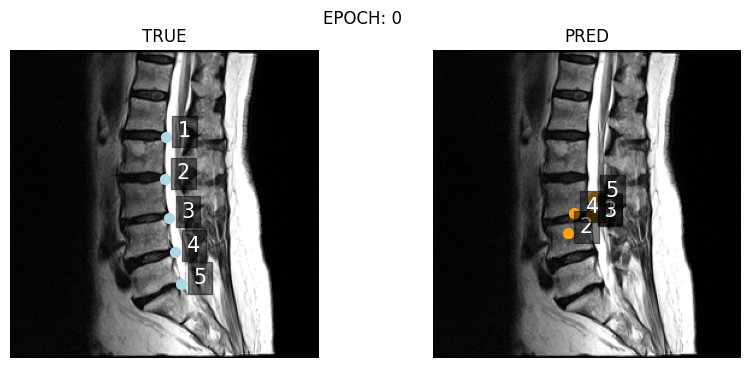

Epoch 1, Training Loss: 0.0, Validation Loss: 0.02208871966493981


100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


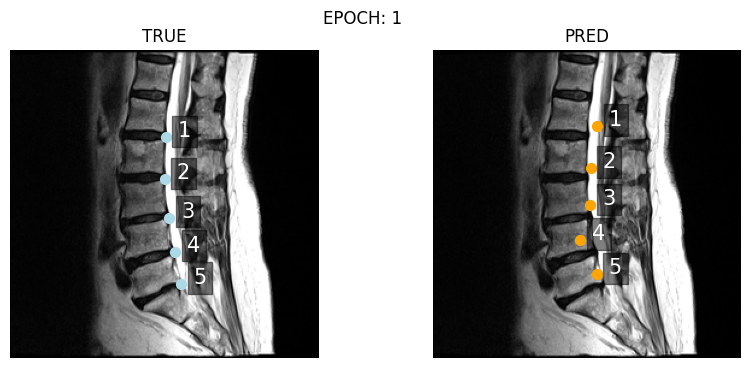

Epoch 2, Training Loss: 0.0008463308331556618, Validation Loss: 0.003838503616861999


100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


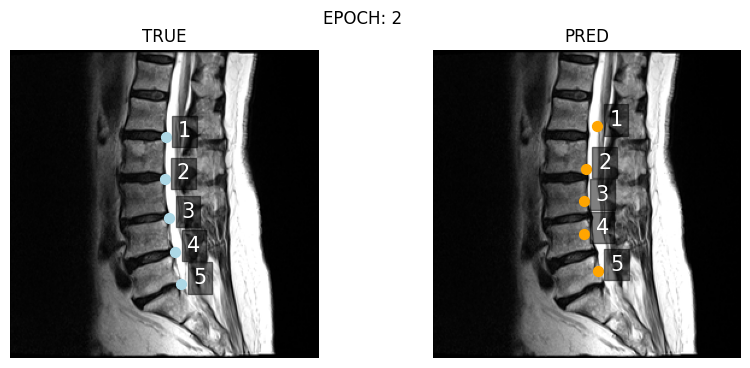

Epoch 3, Training Loss: 0.0013643621932715178, Validation Loss: 0.003594478958153299


100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


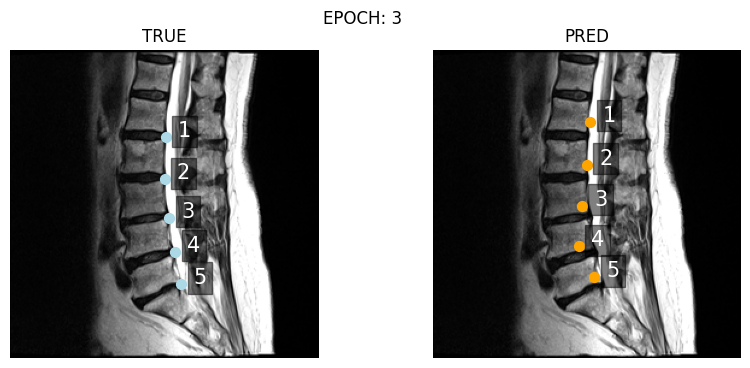

Epoch 4, Training Loss: 0.0006022435845807195, Validation Loss: 0.0033210612268054058


100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


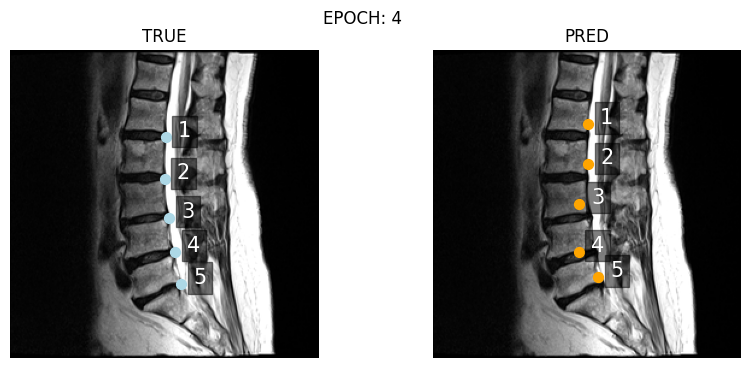

Epoch 5, Training Loss: 0.0003810632333625108, Validation Loss: 0.0031511550852363662


100%|██████████| 14/14 [00:10<00:00,  1.27it/s]


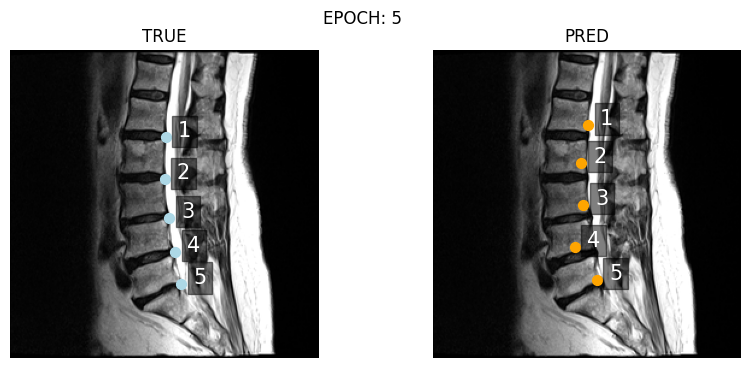

Epoch 6, Training Loss: 0.00027075124671682715, Validation Loss: 0.002770476592039423


100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


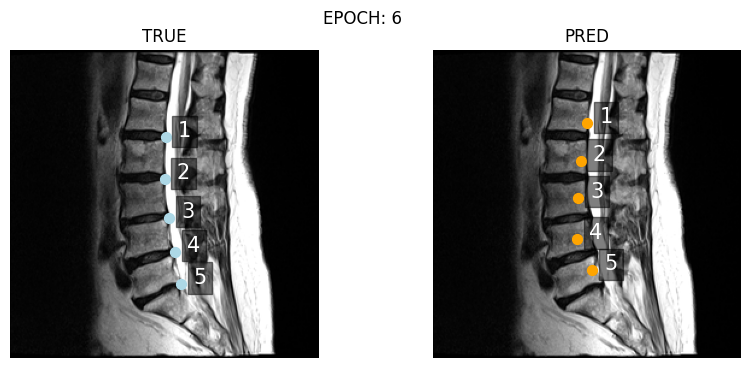

Epoch 7, Training Loss: 0.00026567387976683676, Validation Loss: 0.0028422297909855843


100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


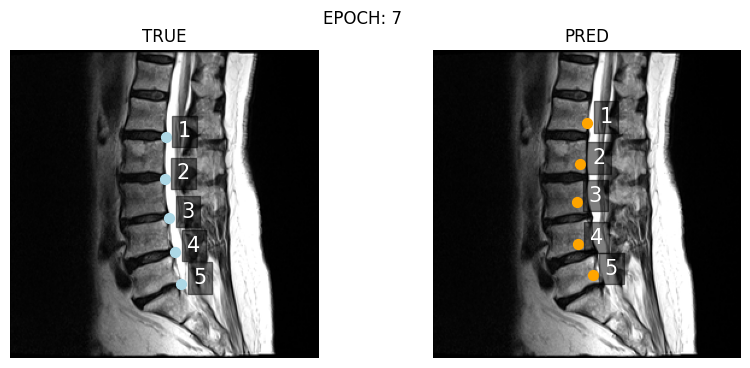

Epoch 8, Training Loss: 0.00038883372326381505, Validation Loss: 0.0031429431068577935


100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


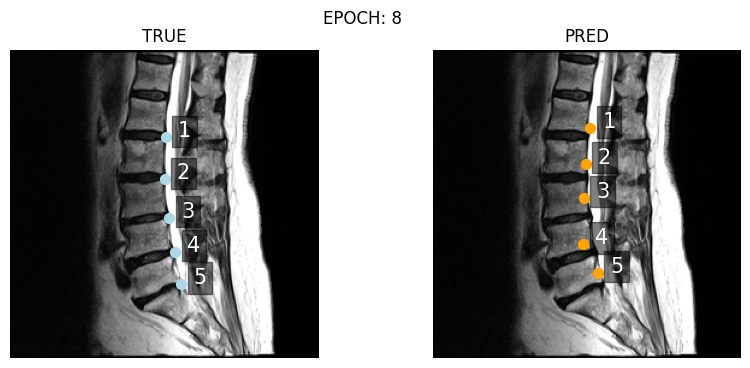

Epoch 9, Training Loss: 0.0005200045416131616, Validation Loss: 0.0026012035086750984


100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


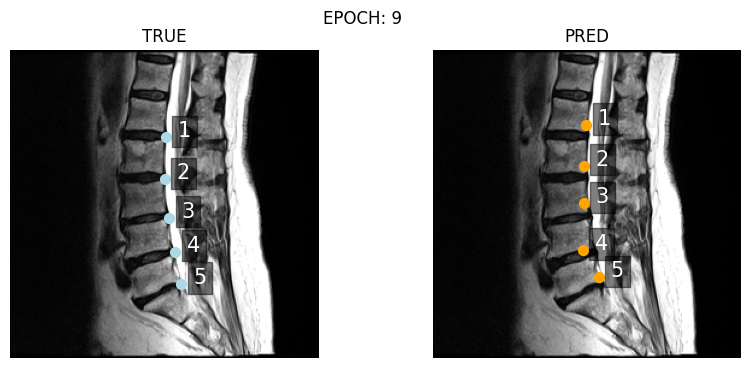

Epoch 10, Training Loss: 0.00017415331967640668, Validation Loss: 0.002913951807256256


100%|██████████| 14/14 [00:12<00:00,  1.11it/s]


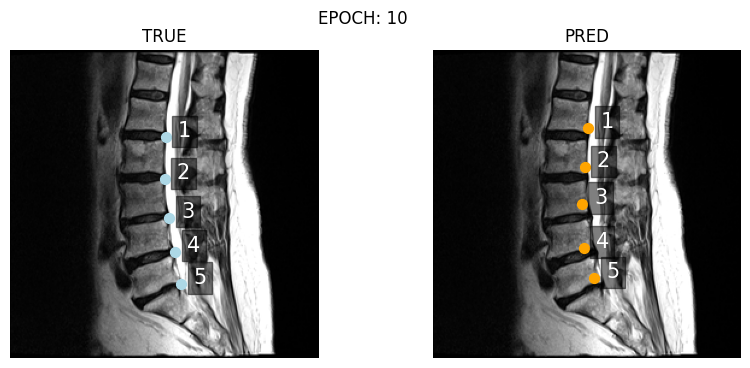

Epoch 11, Training Loss: 0.0001266367908101529, Validation Loss: 0.0027473534074878053
Training complete...


In [26]:
for epoch in range(cfg.epochs+1):
    
    # Train Loop
    loss= torch.tensor([0.]).float().to(cfg.device)
    if epoch != 0:
        model= model.train()
        for batch in tqdm(train_dl):
            batch = batch_to_device(batch, cfg.device)
            optimizer.zero_grad()

            x_out = model(batch["img"].float())
            x_out = torch.sigmoid(x_out)

            loss = criterion(x_out, batch["label"].float())
            loss.backward()
            optimizer.step()
        
    # Validation Loop
    val_loss = 0
    with torch.no_grad():
        model = model.eval()
        for batch in tqdm(val_dl):
            batch = batch_to_device(batch, cfg.device)

            pred = model(batch["img"].float())
            pred = torch.sigmoid(pred)
            
            val_loss += criterion(pred, batch["label"].float()).item()
        val_loss /= len(val_dl)
            
    # Viz
    visualize_prediction(batch, pred, epoch)           
            
    print(f"Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")
print("Training complete...")

In [27]:
f= "{}_{}.pt".format(cfg.backbone, cfg.seed)
torch.save(model.state_dict(), f)
print("Saved weights: {}".format(f))

Saved weights: resnet18_0.pt


In [28]:
model = timm.create_model('resnet18', pretrained=True, num_classes=75)
model = model.to(cfg.device)
load_weights_skip_mismatch(model, f, cfg.device)

Skipping param: fc.weight, torch.Size([10, 512]) != torch.Size([75, 512])
Skipping param: fc.bias, torch.Size([10]) != torch.Size([75])
Loaded weights from: resnet18_0.pt


/tmp/ipykernel_29/719030199.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)
